In [ ]:
!pip install torch
!pip install datashader
!apt-get install libgeos++ libproj-dev
!pip install geoviews

In [45]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import math
from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
userID = 'Sara' #@param ["Jonas", "Klara", "Sara"]

if 'j' in userID[0].lower():
  working_path = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d '/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents'
    os.chdir(working_path) #Jonas connection
elif 's' in userID[0].lower():
  working_path = "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
    os.chdir(working_path) #Sara connection
else:
  working_path = "/content/drive/My Drive/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/project/DataLoaderForStudents"
    os.chdir(working_path) #Klara connection

In [47]:
sys.path.append(f'{working_path}/MMM_DataLoaderForStudents/src')
from data_utils_conda import *
clear_output(wait=False)

In [48]:
from modelClass2Ch9 import *

In [49]:
random.seed(123)
user_train, user_val, user_test = train, val, test = train_test_data_split(Random=True)
user_train = [user for user in user_train if user!=4]
user_test = [user for user in user_test if user!=9]
print("We train on users {}\n we validate on users {}\n and we test on users {}".format(user_train,user_val,user_test))

We train on users [0, 1, 6, 10, 11, 8, 3]
 we validate on users [2]
 and we test on users [5, 7]


### Load data set and adjust labels

In [50]:
# get data
dataset = decompress_pickle(f'{working_path}/MMM_DataLoaderForStudents/Pickle/dataSet.pbz2')
dataset.rename(columns = {"label": "label2"})
labelMeaning = pd.read_csv(f'{working_path}/MMM_DataLoaderForStudents/UID-MMM-labels.csv').drop(columns='Unnamed: 0')[['stop','mode','howTravelled','purpose','mainActivity']]
labelMeaning.head()

,stop,mode,howTravelled,purpose,mainActivity
0,1,0,-100,14,Work
1,2,5,Foot,0,-100
2,1,0,-100,0,-100
3,2,5,Foot,0,-100
4,1,0,-100,14,Work


In [51]:
# change index to 0/1
dataset.label2 = dataset.label2-1

#### Define class weights due to large class im-balance

In [52]:
NUM_CLASSES = 2

In [53]:
#data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
#data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test]).reset_index(drop=True)
# The following should be loaded after training phase. You can add the user 4 here, just fot technical limitations. It should be mentioned in the report.
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test+[4] if 4 in user_test else user_test]).reset_index(drop=True)

In [54]:
#data_train = data_train[data_train['segment_ix'] >= 5]
#data_val = data_val[data_val['segment_ix'] >= 5]
data_test = data_test[data_test['segment_ix'] >= filter_seq]

In [55]:
image_data = {}
#for user_id in user_train + user_val + user_test:
for user_id in user_test:
  image_data[user_id] = np.stack(decompress_pickle(working_path+f'/MMM_DataLoaderForStudents/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
  print(image_data[user_id].shape[0])

14112
22616


In [56]:
demo_dataset = ImageTensorDataset(data_test, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=10, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

X_img : torch.Size([10, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
X_seq : torch.Size([10, 6, 2])
tensor([[18.1245,  1.7921],
        [41.4202, -0.6771],
        [16.4861, -2.0234],
        [16.8027,  2.2207],
        [ 2.2984,  2.9285],
        [17.1140,  2.8859]], dtype=torch.float64)
X_tod : torch.Size([10, 5])
tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
y : torch.Size([10])
tensor(0)


In [57]:
#train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
#val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [58]:
model = CnnNet().cuda()
model.load_state_dict(torch.load(os.getcwd()+"/trained_model_label2_ch9_without_49"))
model.eval()

CnnNet(
  (cnn_layer_1): Sequential(
    (0): Conv2d(11, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.45, inplace=False)
  )
  (cnn_layer_2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.45, inplace=False)
  )
  (rnn_layer): Sequential(
    (0): GRU(2, 4, num_layers=2, batch_first=True, bidirectional=True)
    (1): SelectItem()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Dropout(p=0.45, inplace=False)
  )
  (fc_lay

In [59]:
sum(p.numel() for p in model.parameters())

101224

In [60]:
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
#criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).cuda())

In [61]:
phases = {
    #'train': {
    #    'dataloader': train_dataloader,
    #    'is_training': True,
    #},
    #'validation': {
    #    'dataloader': val_dataloader,
    #    'is_training': False,
    #},
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

In [62]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_seq, X_tod, y = batch
        #X_img = (X_img0[:,:,:,0]+X_img0[:,:,:,1]+X_img0[:,:,:,2]+X_img0[:,:,:,3]+X_img0[:,:,:,9]).reshape(X_img0.size()[0],9,9,1)

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
        X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
        X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
        y = y.float().cuda()#.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy())) 

In [63]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['stop','motion']))

test
              precision    recall  f1-score   support

        stop       0.48      0.17      0.25      3778
      motion       0.84      0.96      0.90     17112

    accuracy                           0.82     20890
   macro avg       0.66      0.56      0.57     20890
weighted avg       0.77      0.82      0.78     20890



In [64]:
confusion_matrix(phase['true'],phase['predicted'])

array([[  632,  3146],
       [  688, 16424]])

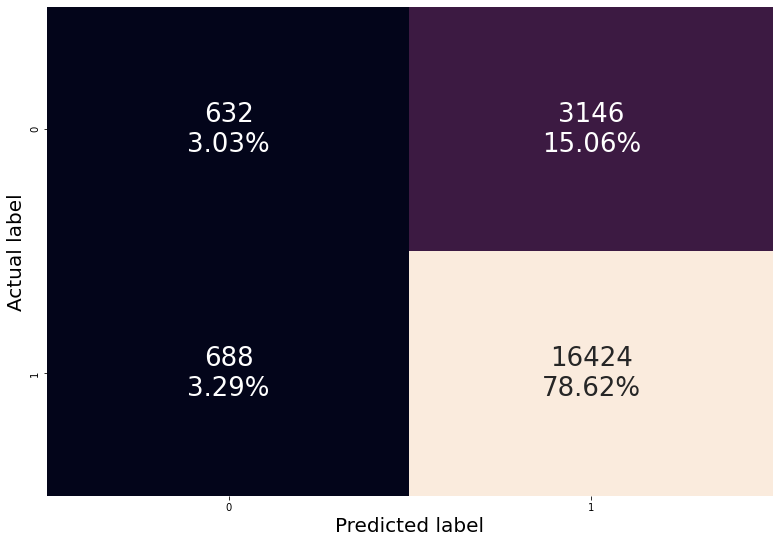

In [65]:
df_cm = confusion_matrix(phase['true'],phase['predicted'])
#df_cm = pd.DataFrame(df_cm, range(2), range(2))

group_counts = ["{0:0.0f}".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(13,9))
sns.heatmap(df_cm, annot=labels, annot_kws={"size": 26}, fmt='', cbar=False) # counts and percentage of total
#sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f', cbar=False) # counts
#sns.heatmap(df_cm/df_cm.sum(), annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False) # precision
#sns.heatmap(df_cm.div(df_cm.sum(axis=1), axis=0), annot=True, annot_kws={"size": 16}, fmt='.2%', cbar=False,
#            xticklabels=['0','1'], yticklabels=['0','1']) # recall
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('Actual label',fontsize=20)
#plt.title('Confusion matrix, with recall scores')
plt.show()